## Focal Loss

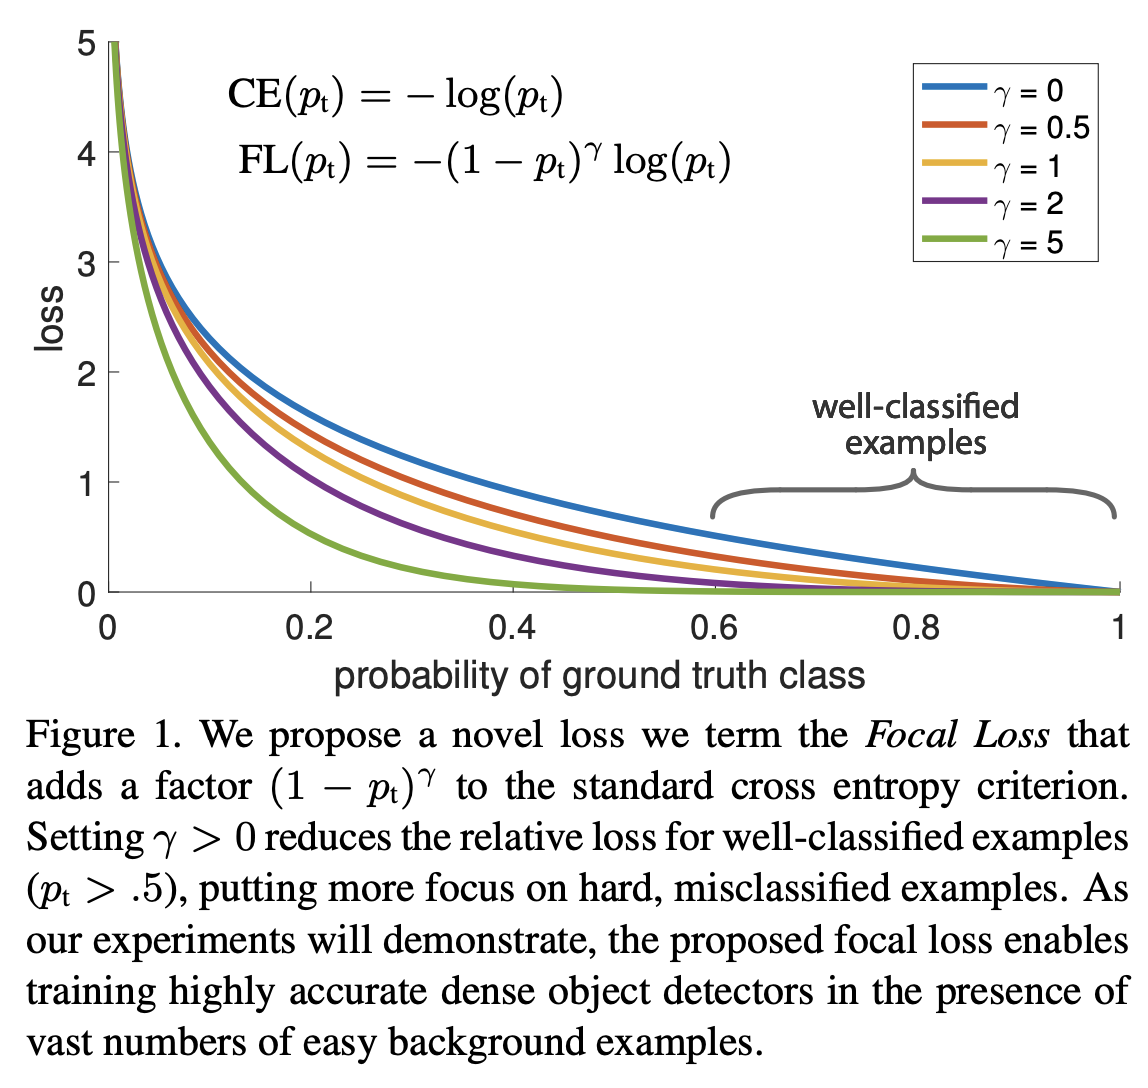

1. Positive examples: Target Class or foreground information such as ground-truths.
2. Negative examples: Non-Target Class or background information such as anchors whose IoU with ground-truths is less than a given threshold.
3. Easy positives/negatives: Samples classified as positive/negative examples.
4. Hard positives/negatives: Samples misclassified as negative/positive examples.

#### Class Imbalance Problem

- This is observed when information related to one class in a dataset or mini-batches used in training is over-represented than the other classes.
- Training a network on an imbalanced dataset will make the network biased towards learning more representations of the data-dominated class and other classes will be underlooked.
- In the case of Object Detection, two confidence values are predicted. One is Objectness score(Whether an object is present in a box or not) and the other is Class score(To which class detected object belong to).
- So it becomes important to maintain a balanced state between foreground-background and foreground-foreground classes while training. If not handled, former creates a box confidence errors(Whether or not an object is present)and the latter creates class confidence errors(If an object is present in the box, then which class does it represent) during training.


#### Story
Let’s consider a scenario of a soccer match. You are seeing your favorite rivalry of Real Madrid vs Barcelona on television. The stadium is fully packed with the audience chanting for their respective teams with a total of 70,000 people. Suddenly Real Madrid scores and whole stadium bursts will the chants of “Goaalll..!!”. No one can hear anything but chants, chants, and chants. 3 commentators are analyzing the match that these telecast reporters want to show on the TV. So what they do to? They give more importance to the commentary and give less weight to the chants so that people watching on television can listen to the commentary and live match analysis. Yes, you will hear the chants while watching but, commentary voice will get more amplified. Remember this analogical example for now.We will see how this example relates to Focal Loss

Let’s devise the equations of Focal Loss step-by-step:

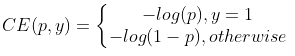

Simplifying this we can write the above as

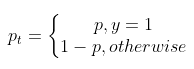

and

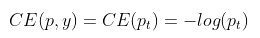

α term is added to the above to handle the class imbalance problem. It is a hyperparameter that can be used with the CE loss function for cross-validation. α_t is a weighted term whose value is α for positive(foreground) class and 1-α for negative(background) class.

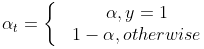

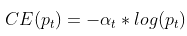

The above equation only handles and controls the weight of positive and negative samples, but it doesn’t take into consideration easy and hard samples. So finally, Focal Loss was designed in such a way that it handles both the mentioned conditions. Two forms of Focal Loss are given below.

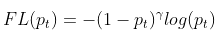


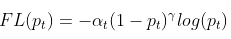



In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Focal Loss function (without reduction for illustration)
def focal_loss(inputs, targets, alpha=1, gamma=2):
    probs = torch.sigmoid(inputs)  # Convert logits to probabilities
    pt = probs * targets + (1 - probs) * (1 - targets)  # Pt = P if true class, 1-P otherwise
    log_pt = torch.log(pt)
    loss = -alpha * (1 - pt) ** gamma * log_pt
    return loss

# Binary Cross-Entropy (BCE) loss for comparison
def bce_loss(inputs, targets):
    return F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')





In [69]:
# Example inputs (logits) and targets
inputs = torch.tensor([0.1, 0.4, 0.7, 0.9, 0.99, -0.1, -0.4, -0.7, -0.9, -0.99])
targets = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0]).float()



# Different gamma values to test
gamma_values = [0, 0.5, 1, 2, 5]
alpha = 1  # We'll keep alpha fixed for now

#Lets understand step by step
probs=torch.sigmoid(inputs)
print(f"targets ==> {targets}")
print(f"probs ==> {probs}")
print(f"************************************")
print(f"***       Focal Loss             ***")
print(f"************************************")
pt = probs * targets + (1 - probs) * (1 - targets) # Gamma=2
print(f"pt ==> {pt}  | The larger the no the accurate the prediction |")
log_pt = -1*torch.log(pt)
print(f"log_pt ==> {log_pt} | The Negative Log increases for nos further from correct prediction |")
print(f"{(1 - pt) ** 2} |Focal loss penalizing the nos with lower probabilities|")
loss = alpha * (1 - pt) ** 2 * log_pt
print(f"loss ==> {loss}")

targets ==> tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
probs ==> tensor([0.5250, 0.5987, 0.6682, 0.7109, 0.7291, 0.4750, 0.4013, 0.3318, 0.2891,
        0.2709])
************************************
***       Focal Loss             ***
************************************
pt ==> tensor([0.5250, 0.5987, 0.6682, 0.7109, 0.7291, 0.5250, 0.5987, 0.6682, 0.7109,
        0.7291])  | The larger the no the accurate the prediction |
log_pt ==> tensor([0.6444, 0.5130, 0.4032, 0.3412, 0.3160, 0.6444, 0.5130, 0.4032, 0.3412,
        0.3160]) | The Negative Log increases for nos further from correct prediction |
tensor([0.2256, 0.1611, 0.1101, 0.0836, 0.0734, 0.2256, 0.1611, 0.1101, 0.0836,
        0.0734]) |Focal loss penalizing the nos with lower probabilities|
* The further away probabilities or losses are exponential*
loss ==> tensor([0.1454, 0.0826, 0.0444, 0.0285, 0.0232, 0.1454, 0.0826, 0.0444, 0.0285,
        0.0232])


In [ ]:
# Calculate and plot losses
plt.figure(figsize=(10, 6))

for gamma in gamma_values:
    fl_loss = focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
    plt.plot(inputs.numpy(), fl_loss.detach().numpy(), label=f'Focal Loss (gamma={gamma})')

# Plot BCE for comparison
bce = bce_loss(inputs, targets)
plt.plot(inputs.numpy(), bce.detach().numpy(), label='BCE Loss', linestyle='--')

plt.xlabel('Logits')
plt.ylabel('Loss')
plt.legend()
plt.title('Effect of gamma in Focal Loss (alpha=1)')
plt.grid(True)
plt.show()

# Test varying alpha with fixed gamma=2
alpha_values = [0.25, 0.5, 1, 2, 4]
gamma = 2

plt.figure(figsize=(10, 6))

for alpha in alpha_values:
    fl_loss = focal_loss(inputs, targets, alpha=alpha, gamma=gamma)
    plt.plot(inputs.numpy(), fl_loss.detach().numpy(), label=f'Focal Loss (alpha={alpha})')

plt.xlabel('Logits')
plt.ylabel('Loss')
plt.legend()
plt.title('Effect of alpha in Focal Loss (gamma=2)')
plt.grid(True)
plt.show()

### Explanation and Observations:
#### Effect of gamma:

- When gamma=0, the focal loss reduces to BCE loss because the (1 - pt) ** gamma term becomes 1.
- As gamma increases, the focal loss increasingly down-weights easy examples (i.e., those where the model is confident), placing more focus on hard examples (those where the model is uncertain or wrong).
- High values of gamma will result in almost no loss contribution from well-classified examples, effectively focusing all learning on hard examples.
#### Effect of alpha:

- alpha is a scaling factor applied to the loss. In a balanced dataset, alpha=1 is typically used.
- If the dataset is imbalanced, alpha can be used to scale the loss for positive and negative classes differently, emphasizing the minority class.
- Higher alpha values increase the loss for the corresponding class, making the model pay more attention to that class.
#### Key Takeaways:
Gamma (γ): Controls how much focus is placed on hard examples. When γ=0, focal loss is equivalent to BCE. Increasing γ focuses the loss on misclassified or uncertain examples.

Alpha (α): Adjusts the relative importance of positive/negative classes. It’s especially useful in imbalanced datasets.

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision



In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
18
18


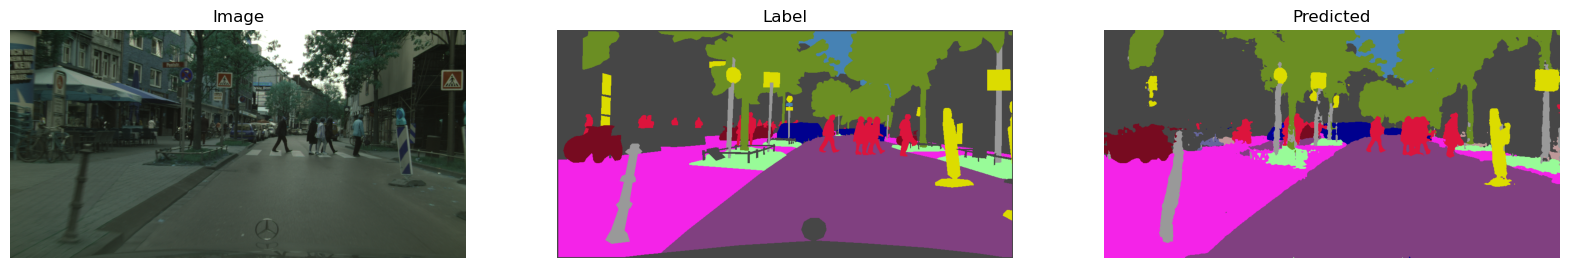

In [54]:
from pipeline.utils import *
import cv2
from matplotlib import pyplot as plt
from losses.focal_loss import *

rgb_image = cv2.imread("pipeline/data/input/aachen_000048_000019.png")
label = cv2.imread("pipeline/data/label/aachen_000048_000019.png",cv2.IMREAD_GRAYSCALE)
output= cv2.imread("pipeline/data/predicted/aachen_000048_000019.png",cv2.IMREAD_GRAYSCALE)
label[label==19]=2
cm_labels = (train_id_to_color[output]).astype(np.uint8)
output_pred = cm_labels[..., ::-1] # Rearrange channels to be  RGB as CV2 thinks train_id_to_color is BGR
output_pred=cv2.cvtColor(output_pred, cv2.COLOR_BGR2RGB)

label_pred= color_to_label_image(train_id_to_color[label],train_id_to_color) #Convert label_pred back to
print(np.all(label==label_pred))

print(np.max(label))
print(np.max(output))
# plot sample image
fig, axes = plt.subplots(1,3, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');
axes[2].imshow(output_pred);
axes[2].set_title("Predicted");
axes[2].axis('off');

In [55]:
pred=torch.load("pipeline/data/predicted/aachen_000000_000019.pt")
print(pred.shape)
label=torch.tensor(label,dtype=torch.int64)
tensor_label=label[None,:,:]
print(tensor_label.shape)
pred.to(device)
tensor_label.to(device)
loss = focal_loss_multiclass(pred , tensor_label)
loss2 = focal_loss_multiclass(pred , tensor_label,alpha=0.25, gamma=2)

print(f"Focal Loss1: {loss.item()} | Focal Loss2: {loss2.item()} " )

torch.Size([1, 19, 512, 1024])
torch.Size([1, 512, 1024])
Focal Loss1: 1.7727792263031006 | Focal Loss2: 1.7727792263031006 


/tmp/ipykernel_1962549/2022435437.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred=torch.load("pipeline/data/predicted/aachen_000000_000019.pt")


In [56]:
import torchvision

labels_one_hot = F.one_hot(tensor_label, num_classes=pred.shape[1])  # Shape: (N, H, W, C)
labels_one_hot = labels_one_hot.permute(0, 3, 1, 2)  # Shape: (N, C, H, W)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move tensors to the device
labels_one_hot = labels_one_hot.float().to(device)
pred = pred.to(device)

# Compute the loss
loss = torchvision.ops.sigmoid_focal_loss(pred, labels_one_hot)

# Reduce the loss tensor to a scalar
loss_value = loss.mean()

# Convert the scalar tensor to a Python number
print(loss_value.item())


loss3= focal_loss_binary(pred , labels_one_hot)
print(loss3.item())


0.5094504356384277
0.6501034498214722
